In [9]:
import pygrib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import logging
import sys
import requests
from datetime import datetime, timedelta

from pvlib import pvsystem, modelchain, location, irradiance
from pvlib.solarposition import get_solarposition
from pvlib import irradiance, solarposition

In [20]:
def get_hourly_weather_data_for_pvlib(stations, start_date, end_date, timezone='UTC'):
    '''
    Function to get hourly weather variables T (temperature) and
    Q (global radiation) from KNMI 
    
    Args: 
        stations   (str): NMI-stations separated by ':' 
        start_date (str): start date, format yyyymmdd
        end_date   (str): end date (included), format yyyymmdd
        timezone   (str, optional): timezone

    Returns:
        df: DataFrame with DateTime-index, columns T (temp), Q (global radiation) 
    '''

    url = 'https://www.daggegevens.knmi.nl/klimatologie/uurgegevens'

    data = {
        'start': start_date,
        'end': end_date,
        'vars': 'Q:T:FH',
        'stns': stations,
        'fmt': 'json'
    }

    response = requests.post(url, data=data)    
    weather_df = pd.DataFrame(response.json())
    
    # correct units
    weather_df['T'] = weather_df['T'] / 10          # is in 0.1 degrees C, to degrees C
    weather_df['Q'] = weather_df['Q'] * (1/0.36)    # is in J/cm2, to W / m2
    weather_df['FH'] = weather_df['FH']  * 0.1      # from 0.1 m/s to m/s         
    
    # create date_time index, convert timezone
    weather_df['hour'] = weather_df['hour'] - 1     # is from 1-24, to 0-23
    weather_df['date_time'] = pd.to_datetime(weather_df['date']) + pd.to_timedelta(weather_df['hour'].astype(int), unit='h')
    weather_df.index = weather_df.date_time
    
    weather_df = weather_df.drop(['station_code', 'date', 'hour', 'date_time'], axis=1)
    weather_df.index = weather_df.index.tz_convert(timezone)

    return weather_df

def process_weather_data(weather_df: pd.DataFrame, lat: float, lon: float) -> pd.DataFrame:
    """
    Process weather data to calculate DNI and DHI.

    Parameters:
    - weather_df: DataFrame containing weather data with datetime index, temperature (T), and GHI (Q).
    - lat: Latitude of the location.
    - lon: Longitude of the location.

    Returns:
    - DataFrame: Processed weather data with added DNI, DHI, no NaN values.
    """
    # Get solar position for the dates / times
    solpos_df = solarposition.get_solarposition(
        weather_df.index, latitude=lat,
        longitude=lon, altitude=0,
        temperature=weather_df['T']
    )
    solpos_df.index = weather_df.index

    # Method 'Erbs' to go from GHI to DNI and DHI
    irradiance_df = irradiance.erbs(weather_df['Q'], solpos_df['zenith'], weather_df.index)
    irradiance_df['ghi'] = weather_df['Q']

    # Add DNI and DHI to weather_df
    columns = ['dni', 'dhi']
    weather_df[columns] = irradiance_df[columns]

    # Fill NaN values with 0
    weather_df.fillna(0, inplace=True)
    
    return weather_df

# Parameters
timezone = 'Europe/Amsterdam'
start_date = '20240529'
end_date = '20240531'
station = '370'
lat = 51.449772459909
lon = 5.3770039280214

# Fetch and process weather data
weather_df = get_hourly_weather_data_for_pvlib(station, start_date, end_date, timezone)
weather_df = process_weather_data(weather_df, lat, lon)

print(weather_df)

                                    Q     T   FH         dni         dhi
date_time                                                               
2024-05-29 02:00:00+02:00    0.000000  15.0  4.0    0.000000    0.000000
2024-05-29 03:00:00+02:00    0.000000  14.8  5.0    0.000000    0.000000
2024-05-29 04:00:00+02:00    0.000000  14.6  5.0    0.000000    0.000000
2024-05-29 05:00:00+02:00    0.000000  14.5  6.0    0.000000    0.000000
2024-05-29 06:00:00+02:00   11.111111  14.6  5.0    2.401157   10.982422
2024-05-29 07:00:00+02:00   61.111111  14.7  6.0    6.732842   59.773781
2024-05-29 08:00:00+02:00  150.000000  15.2  6.0   29.653992  139.626736
2024-05-29 09:00:00+02:00  261.111111  16.2  7.0   80.743274  220.994173
2024-05-29 10:00:00+02:00  380.555556  16.5  7.0  152.227336  284.694628
2024-05-29 11:00:00+02:00  416.666667  17.1  6.0  111.572074  334.171096
2024-05-29 12:00:00+02:00  461.111111  16.7  6.0  111.491307  369.867557
2024-05-29 13:00:00+02:00  513.888889  18.0  7.0  1

In [21]:
print(weather_df)

                                    Q     T   FH         dni         dhi
date_time                                                               
2024-05-29 02:00:00+02:00    0.000000  15.0  4.0    0.000000    0.000000
2024-05-29 03:00:00+02:00    0.000000  14.8  5.0    0.000000    0.000000
2024-05-29 04:00:00+02:00    0.000000  14.6  5.0    0.000000    0.000000
2024-05-29 05:00:00+02:00    0.000000  14.5  6.0    0.000000    0.000000
2024-05-29 06:00:00+02:00   11.111111  14.6  5.0    2.401157   10.982422
2024-05-29 07:00:00+02:00   61.111111  14.7  6.0    6.732842   59.773781
2024-05-29 08:00:00+02:00  150.000000  15.2  6.0   29.653992  139.626736
2024-05-29 09:00:00+02:00  261.111111  16.2  7.0   80.743274  220.994173
2024-05-29 10:00:00+02:00  380.555556  16.5  7.0  152.227336  284.694628
2024-05-29 11:00:00+02:00  416.666667  17.1  6.0  111.572074  334.171096
2024-05-29 12:00:00+02:00  461.111111  16.7  6.0  111.491307  369.867557
2024-05-29 13:00:00+02:00  513.888889  18.0  7.0  1

In [22]:
# Eindhoven
eindhoven_lat = 51.4416
eindhoven_lon = 5.4697

# Folder grib files
grib_folder = r"C:\Users\20193362\Desktop\InterProject\InterdisciplinaryProject\energy_prediction\harm40_v1_p1_2024052900"

# List needed parameters, see code matrix KNMI
parameters = {"temperature": "11", "windU": "33", "windV": "34", "globalRadiation":  "117"}

# Initialize list to hold the data
data_list = []

# Loop over each file 
for file_name in os.listdir(grib_folder):
    if file_name.endswith('_GB'):
        grib_file = os.path.join(grib_folder, file_name)
        grbs = pygrib.open(grib_file)
        
        # Retrieve the lat/lon grid
        first_message = grbs.message(1)
        lats, lons = first_message.latlons()
        
        # Find the closest grid point
        distance = np.sqrt((lats - eindhoven_lat)**2 + (lons - eindhoven_lon)**2)
        min_index = distance.argmin()
        nearest_point_lat = lats.flat[min_index]
        nearest_point_lon = lons.flat[min_index]

        data_date = str(first_message.dataDate)  # Format: YYYYMMDD
        data_time = first_message.dataTime  # Format: HHMM
        
        # Create the base datetime object from dataDate and dataTime
        base_datetime = datetime.strptime(f"{data_date} {data_time:04d}", "%Y%m%d %H%M")
        step_range = float(first_message.stepRange)
        valid_datetime = base_datetime + timedelta(hours=step_range)
        
        # Initialize a dictionary to hold the data for this file
        data_dict = {
            'file_name': file_name,
            'datetime': valid_datetime #,
            #'latitude': nearest_point_lat,
            #'longitude': nearest_point_lon
        }
        
        # Extract data for each parameter
        for key in parameters:
            try:
                grb_message = grbs.select(parameterName=parameters[key])[0] # First instance
                parameter_name = key
                eindhoven_value = grb_message.values.flat[min_index]
                data_dict[parameter_name] = eindhoven_value
            except (IndexError, ValueError):
                data_dict[parameter_name] = np.nan # When parameter is not found in grib file
        
        grbs.close()
        
        # Append dictionary to list
        data_list.append(data_dict)

# Convert list of dictionaries to DF
gribData = pd.DataFrame(data_list)
df = gribData.copy()

df['windSpeed'] = np.sqrt(df['windU']**2 + df['windV']**2)
df['temperature'] = df['temperature'] - 272.15

df['globalRadiation'] = df['globalRadiation'].fillna(0)
# Calculate the difference between consecutive rows
df['Q'] = df['globalRadiation'].diff()
df['Q'] = df ['Q'] / 3600

forecastweather_df = df.copy()
# Get solar position for the dates / times
solpos_df = solarposition.get_solarposition(
    forecastweather_df['datetime'], latitude=eindhoven_lat,
    longitude=eindhoven_lon, altitude=0,
    temperature=forecastweather_df['temperature']
)
solpos_df.index = forecastweather_df.index

# Method 'Erbs' to go from GHI to DNI and DHI
irradiance_df = irradiance.erbs(forecastweather_df['Q'], solpos_df['zenith'], forecastweather_df.index)
irradiance_df['ghi'] = forecastweather_df['Q']

# Add DNI and DHI to weather_df
forecastweather_df['dni'] = irradiance_df['dni']
forecastweather_df['dhi'] = irradiance_df['dhi']


forecastweather_df = forecastweather_df.drop(['windU', 'windV'], axis=1)
forecastweather_df = forecastweather_df[:-1]
forecastweather_df = forecastweather_df.fillna(0)

print(forecastweather_df)

                         file_name            datetime  temperature  \
0   HA40_N25_202405290000_00000_GB 2024-05-29 00:00:00    15.719385   
1   HA40_N25_202405290000_00100_GB 2024-05-29 01:00:00    15.551904   
2   HA40_N25_202405290000_00200_GB 2024-05-29 02:00:00    15.408838   
3   HA40_N25_202405290000_00300_GB 2024-05-29 03:00:00    15.307031   
4   HA40_N25_202405290000_00400_GB 2024-05-29 04:00:00    15.463770   
5   HA40_N25_202405290000_00500_GB 2024-05-29 05:00:00    15.528223   
6   HA40_N25_202405290000_00600_GB 2024-05-29 06:00:00    15.560327   
7   HA40_N25_202405290000_00700_GB 2024-05-29 07:00:00    15.804834   
8   HA40_N25_202405290000_00800_GB 2024-05-29 08:00:00    16.125879   
9   HA40_N25_202405290000_00900_GB 2024-05-29 09:00:00    15.691064   
10  HA40_N25_202405290000_01000_GB 2024-05-29 10:00:00    15.560693   
11  HA40_N25_202405290000_01100_GB 2024-05-29 11:00:00    15.911768   
12  HA40_N25_202405290000_01200_GB 2024-05-29 12:00:00    16.234033   
13  HA

In [23]:
print(weather_df)

                                    Q     T   FH         dni         dhi
date_time                                                               
2024-05-29 02:00:00+02:00    0.000000  15.0  4.0    0.000000    0.000000
2024-05-29 03:00:00+02:00    0.000000  14.8  5.0    0.000000    0.000000
2024-05-29 04:00:00+02:00    0.000000  14.6  5.0    0.000000    0.000000
2024-05-29 05:00:00+02:00    0.000000  14.5  6.0    0.000000    0.000000
2024-05-29 06:00:00+02:00   11.111111  14.6  5.0    2.401157   10.982422
2024-05-29 07:00:00+02:00   61.111111  14.7  6.0    6.732842   59.773781
2024-05-29 08:00:00+02:00  150.000000  15.2  6.0   29.653992  139.626736
2024-05-29 09:00:00+02:00  261.111111  16.2  7.0   80.743274  220.994173
2024-05-29 10:00:00+02:00  380.555556  16.5  7.0  152.227336  284.694628
2024-05-29 11:00:00+02:00  416.666667  17.1  6.0  111.572074  334.171096
2024-05-29 12:00:00+02:00  461.111111  16.7  6.0  111.491307  369.867557
2024-05-29 13:00:00+02:00  513.888889  18.0  7.0  1

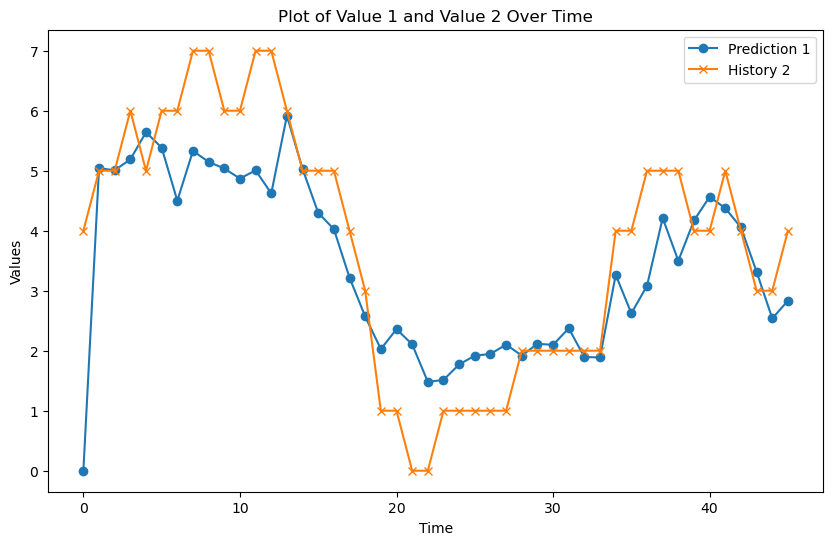

date_time
2024-05-29 02:00:00+02:00      0.000000
2024-05-29 03:00:00+02:00      0.000000
2024-05-29 04:00:00+02:00      0.000000
2024-05-29 05:00:00+02:00      0.000000
2024-05-29 06:00:00+02:00     11.111111
2024-05-29 07:00:00+02:00     61.111111
2024-05-29 08:00:00+02:00    150.000000
2024-05-29 09:00:00+02:00    261.111111
2024-05-29 10:00:00+02:00    380.555556
2024-05-29 11:00:00+02:00    416.666667
2024-05-29 12:00:00+02:00    461.111111
2024-05-29 13:00:00+02:00    513.888889
2024-05-29 14:00:00+02:00    597.222222
2024-05-29 15:00:00+02:00    366.666667
2024-05-29 16:00:00+02:00    494.444444
2024-05-29 17:00:00+02:00    472.222222
2024-05-29 18:00:00+02:00    402.777778
2024-05-29 19:00:00+02:00    255.555556
2024-05-29 20:00:00+02:00    108.333333
2024-05-29 21:00:00+02:00     11.111111
2024-05-29 22:00:00+02:00      0.000000
2024-05-29 23:00:00+02:00      0.000000
2024-05-30 00:00:00+02:00      0.000000
2024-05-30 01:00:00+02:00      0.000000
2024-05-30 02:00:00+02:00     

In [24]:
df1 = forecastweather_df.copy()
df2 = weather_df.copy()
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot column 'value1' from df1
plt.plot(range(0,46), df1['windSpeed'][:46], label='Prediction 1', marker='o')

# Plot column 'value2' from df2
plt.plot(range(0,46), df2['FH'][:46], label='History 2', marker='x')

# Adding titles and labels
plt.title('Plot of Value 1 and Value 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

print(df2['Q'])


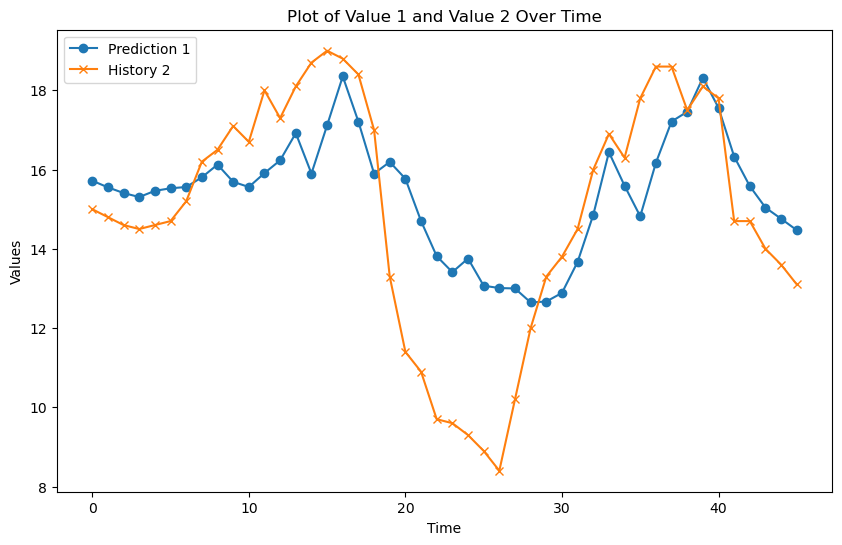

date_time
2024-05-29 02:00:00+02:00      0.000000
2024-05-29 03:00:00+02:00      0.000000
2024-05-29 04:00:00+02:00      0.000000
2024-05-29 05:00:00+02:00      0.000000
2024-05-29 06:00:00+02:00     11.111111
2024-05-29 07:00:00+02:00     61.111111
2024-05-29 08:00:00+02:00    150.000000
2024-05-29 09:00:00+02:00    261.111111
2024-05-29 10:00:00+02:00    380.555556
2024-05-29 11:00:00+02:00    416.666667
2024-05-29 12:00:00+02:00    461.111111
2024-05-29 13:00:00+02:00    513.888889
2024-05-29 14:00:00+02:00    597.222222
2024-05-29 15:00:00+02:00    366.666667
2024-05-29 16:00:00+02:00    494.444444
2024-05-29 17:00:00+02:00    472.222222
2024-05-29 18:00:00+02:00    402.777778
2024-05-29 19:00:00+02:00    255.555556
2024-05-29 20:00:00+02:00    108.333333
2024-05-29 21:00:00+02:00     11.111111
2024-05-29 22:00:00+02:00      0.000000
2024-05-29 23:00:00+02:00      0.000000
2024-05-30 00:00:00+02:00      0.000000
2024-05-30 01:00:00+02:00      0.000000
2024-05-30 02:00:00+02:00     

In [25]:
df1 = forecastweather_df.copy()
df2 = weather_df.copy()
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot column 'value1' from df1
plt.plot(range(0,46), df1['temperature'][:46], label='Prediction 1', marker='o')

# Plot column 'value2' from df2
plt.plot(range(0,46), df2['T'][:46], label='History 2', marker='x')

# Adding titles and labels
plt.title('Plot of Value 1 and Value 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

print(df2['Q'])


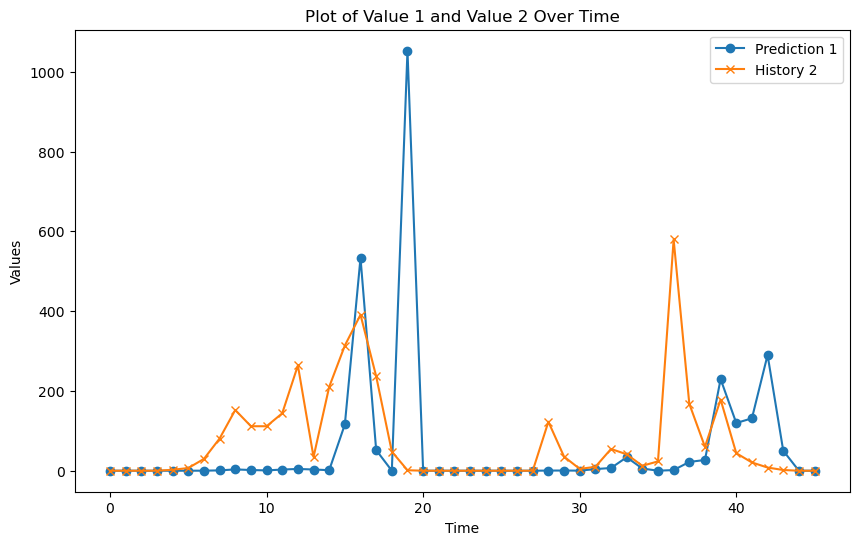

date_time
2024-05-29 02:00:00+02:00      0.000000
2024-05-29 03:00:00+02:00      0.000000
2024-05-29 04:00:00+02:00      0.000000
2024-05-29 05:00:00+02:00      0.000000
2024-05-29 06:00:00+02:00     11.111111
2024-05-29 07:00:00+02:00     61.111111
2024-05-29 08:00:00+02:00    150.000000
2024-05-29 09:00:00+02:00    261.111111
2024-05-29 10:00:00+02:00    380.555556
2024-05-29 11:00:00+02:00    416.666667
2024-05-29 12:00:00+02:00    461.111111
2024-05-29 13:00:00+02:00    513.888889
2024-05-29 14:00:00+02:00    597.222222
2024-05-29 15:00:00+02:00    366.666667
2024-05-29 16:00:00+02:00    494.444444
2024-05-29 17:00:00+02:00    472.222222
2024-05-29 18:00:00+02:00    402.777778
2024-05-29 19:00:00+02:00    255.555556
2024-05-29 20:00:00+02:00    108.333333
2024-05-29 21:00:00+02:00     11.111111
2024-05-29 22:00:00+02:00      0.000000
2024-05-29 23:00:00+02:00      0.000000
2024-05-30 00:00:00+02:00      0.000000
2024-05-30 01:00:00+02:00      0.000000
2024-05-30 02:00:00+02:00     

In [26]:
df1 = forecastweather_df.copy()
df2 = weather_df.copy()
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot column 'value1' from df1
plt.plot(range(0,46), df1['dni'][:46], label='Prediction 1', marker='o')

# Plot column 'value2' from df2
plt.plot(range(0,46), df2['dni'][:46], label='History 2', marker='x')

# Adding titles and labels
plt.title('Plot of Value 1 and Value 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

print(df2['Q'])


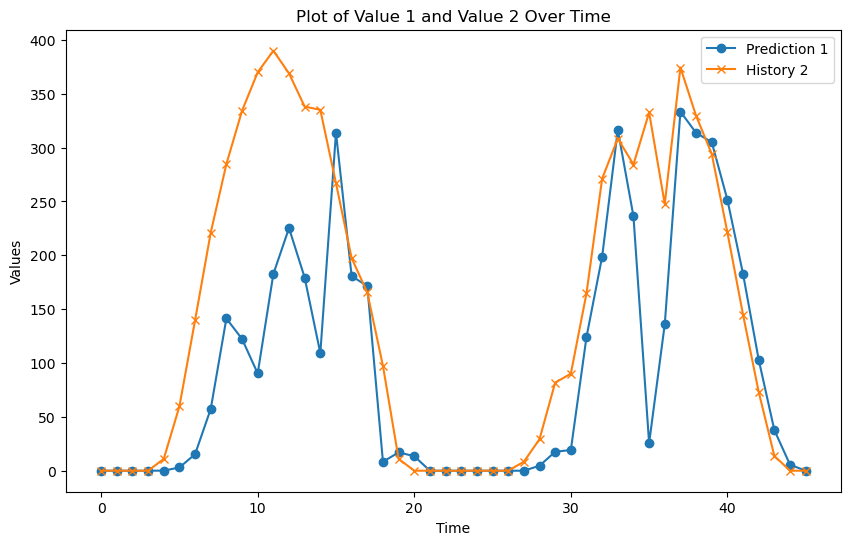

date_time
2024-05-29 02:00:00+02:00      0.000000
2024-05-29 03:00:00+02:00      0.000000
2024-05-29 04:00:00+02:00      0.000000
2024-05-29 05:00:00+02:00      0.000000
2024-05-29 06:00:00+02:00     11.111111
2024-05-29 07:00:00+02:00     61.111111
2024-05-29 08:00:00+02:00    150.000000
2024-05-29 09:00:00+02:00    261.111111
2024-05-29 10:00:00+02:00    380.555556
2024-05-29 11:00:00+02:00    416.666667
2024-05-29 12:00:00+02:00    461.111111
2024-05-29 13:00:00+02:00    513.888889
2024-05-29 14:00:00+02:00    597.222222
2024-05-29 15:00:00+02:00    366.666667
2024-05-29 16:00:00+02:00    494.444444
2024-05-29 17:00:00+02:00    472.222222
2024-05-29 18:00:00+02:00    402.777778
2024-05-29 19:00:00+02:00    255.555556
2024-05-29 20:00:00+02:00    108.333333
2024-05-29 21:00:00+02:00     11.111111
2024-05-29 22:00:00+02:00      0.000000
2024-05-29 23:00:00+02:00      0.000000
2024-05-30 00:00:00+02:00      0.000000
2024-05-30 01:00:00+02:00      0.000000
2024-05-30 02:00:00+02:00     

In [27]:
df1 = forecastweather_df.copy()
df2 = weather_df.copy()
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot column 'value1' from df1
plt.plot(range(0,46), df1['dhi'][:46], label='Prediction 1', marker='o')

# Plot column 'value2' from df2
plt.plot(range(0,46), df2['dhi'][:46], label='History 2', marker='x')

# Adding titles and labels
plt.title('Plot of Value 1 and Value 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

print(df2['Q'])


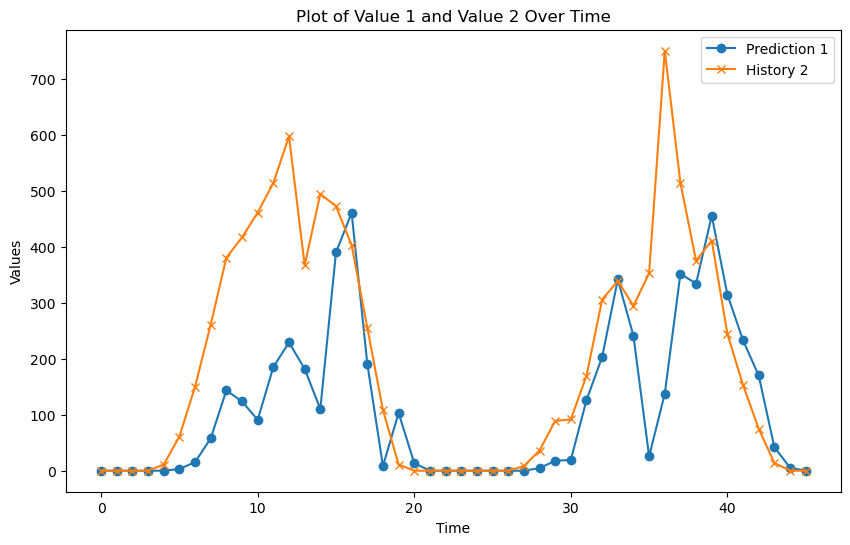

date_time
2024-05-29 02:00:00+02:00      0.000000
2024-05-29 03:00:00+02:00      0.000000
2024-05-29 04:00:00+02:00      0.000000
2024-05-29 05:00:00+02:00      0.000000
2024-05-29 06:00:00+02:00     11.111111
2024-05-29 07:00:00+02:00     61.111111
2024-05-29 08:00:00+02:00    150.000000
2024-05-29 09:00:00+02:00    261.111111
2024-05-29 10:00:00+02:00    380.555556
2024-05-29 11:00:00+02:00    416.666667
2024-05-29 12:00:00+02:00    461.111111
2024-05-29 13:00:00+02:00    513.888889
2024-05-29 14:00:00+02:00    597.222222
2024-05-29 15:00:00+02:00    366.666667
2024-05-29 16:00:00+02:00    494.444444
2024-05-29 17:00:00+02:00    472.222222
2024-05-29 18:00:00+02:00    402.777778
2024-05-29 19:00:00+02:00    255.555556
2024-05-29 20:00:00+02:00    108.333333
2024-05-29 21:00:00+02:00     11.111111
2024-05-29 22:00:00+02:00      0.000000
2024-05-29 23:00:00+02:00      0.000000
2024-05-30 00:00:00+02:00      0.000000
2024-05-30 01:00:00+02:00      0.000000
2024-05-30 02:00:00+02:00     

In [28]:
df1 = forecastweather_df.copy()
df2 = weather_df.copy()
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot column 'value1' from df1
plt.plot(range(0,46), df1['Q'][:46], label='Prediction 1', marker='o')

# Plot column 'value2' from df2
plt.plot(range(0,46), df2['Q'][:46], label='History 2', marker='x')

# Adding titles and labels
plt.title('Plot of Value 1 and Value 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

print(df2['Q'])
